In [ ]:
import pandas as pd
import numpy as np
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

In [ ]:
df = pd.read_csv('GOOG.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2005-01-24,4.699635,4.715575,4.491166,4.501129,4.501129,563010421.0
1,2005-01-25,4.531515,4.538987,4.390792,4.411465,4.411465,427966132.0
2,2005-01-26,4.465014,4.717567,4.462025,4.713333,4.713333,494161321.0
3,2005-01-27,4.701378,4.703869,4.612710,4.684442,4.684442,266089645.0
4,2005-01-28,4.732760,4.849324,4.641104,4.740731,4.740731,490158373.0


In [ ]:
dataframe = df.drop(columns = ['Open', 'High', 'Low', 'Adj Close', 'Volume'])

In [ ]:
dataframe.head()

,Date,Close
0,2005-01-24,4.501129
1,2005-01-25,4.411465
2,2005-01-26,4.713333
3,2005-01-27,4.684442
4,2005-01-28,4.740731


In [ ]:
data = dataframe.copy()
data.set_index('Date', inplace = True)
loopback = 7
for i in range(loopback):
  data[f't-{i+1}'] = data['Close'].shift(i+1)
data.dropna(inplace = True)
data.tail()

,Close,t-1,t-2,t-3,t-4,t-5,t-6,t-7
Date,,,,,,,,
2023-10-16,140.490005,138.580002,140.289993,141.699997,139.199997,139.500000,138.729996,135.990005
2023-10-17,140.990005,140.490005,138.580002,140.289993,141.699997,139.199997,139.500000,138.729996
2023-10-18,139.279999,140.990005,140.490005,138.580002,140.289993,141.699997,139.199997,139.500000
2023-10-19,138.979996,139.279999,140.990005,140.490005,138.580002,140.289993,141.699997,139.199997
2023-10-20,136.740005,138.979996,139.279999,140.990005,140.490005,138.580002,140.289993,141.699997


In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (-1, 1))
training_data = scaler.fit_transform(data)
X = training_data[:, 1:]
X = np.flip(X, axis=1)
X = X.reshape(X.shape[0], X.shape[1], -1)
y = training_data[:, :1]
print(X.shape, y.shape)

(4712, 7, 1) (4712, 1)


In [ ]:
split_index = int(0.9*X.shape[0])
X_train = torch.tensor(X[:split_index].copy()).float()
y_train = torch.tensor(y[:split_index].copy()).float()
X_test = torch.tensor(X[split_index:].copy()).float()
y_test = torch.tensor(y[split_index:].copy()).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([4240, 7, 1]),
 torch.Size([472, 7, 1]),
 torch.Size([4240, 1]),
 torch.Size([472, 1]))

In [ ]:
class StockDataset(Dataset):
  def __init__(self, X, y, transform = None):
    self.X = X
    self.y = y
    self.transform = transform
  def __len__(self):
    return len(self.X)
  def __getitem__(self, index):
    sample = self.X[index]
    label = self.y[index]
    if self.transform:
      sample = self.transform(sample)
      label = self.transform(label)
    return sample, label

In [ ]:
train_dataset = StockDataset(X_train, y_train)
test_dataset = StockDataset(X_test, y_test)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = 32)

In [ ]:
for batch, labels in train_loader:
  print(batch.shape)
  print(labels.shape)
  break

torch.Size([32, 7, 1])
torch.Size([32, 1])


In [ ]:
import torch.nn as nn
class StockNET(nn.Module):
  def __init__(self, input_size, hidden_size, output_size, num_layers):
    super(StockNET, self).__init__()
    self.hidden_size = hidden_size
    self.num_layers = num_layers

    self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first = True)
    self.fc = nn.Linear(hidden_size, output_size)

  def forward(self, x):
    h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
    c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
    out, _ = self.lstm(x, (h_0, c_0)) # -> [32, 7, 4]
    out = out[:, -1, :] # -> [32, 4]
    return self.fc(out) # -> [32, 1]

In [ ]:
from torch.optim import Adam

input_size = 1
hidden_size = 4
num_layers = 2
output_size = 1

model = StockNET(input_size, hidden_size, output_size, num_layers).to(torch.float32)
optimizer = Adam(model.parameters(), lr = 0.001)
criterion = nn.MSELoss()

In [ ]:
#Training Loop
EPOCHS = 9
for epoch in range(EPOCHS):
  total_train_loss = 0
  total_test_loss = 0
  n_train_samples = 0
  n_test_samples = 0
  model.train()
  for i, (batch, val) in enumerate(train_loader):
    output = model(batch)
    optimizer.zero_grad()
    loss = criterion(output, val)
    loss.backward()
    optimizer.step()

    total_train_loss += loss
    n_train_samples += val.size(0)

  model.eval()
  with torch.no_grad():
    for i, (batch, val) in enumerate(test_loader):
      output = model(batch)

      total_test_loss += loss
      n_test_samples += val.size(0)

  print(f'Epoch : {epoch + 1} | Train Loss : {total_train_loss/n_train_samples} | Test Loss : {total_test_loss/n_test_samples}')


Epoch : 1 | Train Loss : 0.005696028005331755 | Test Loss : 0.0041834041476249695
Epoch : 2 | Train Loss : 0.003263224149122834 | Test Loss : 0.002290655393153429
Epoch : 3 | Train Loss : 0.0006639664643444121 | Test Loss : 0.0002964248415082693
Epoch : 4 | Train Loss : 0.0002766902616713196 | Test Loss : 6.418578414013609e-05
Epoch : 5 | Train Loss : 9.572977432981133e-05 | Test Loss : 4.022960638394579e-05
Epoch : 6 | Train Loss : 3.075121276197024e-05 | Test Loss : 1.7278998711844906e-05
Epoch : 7 | Train Loss : 1.927113044075668e-05 | Test Loss : 1.747607529978268e-05
Epoch : 8 | Train Loss : 1.6793304894235916e-05 | Test Loss : 1.5622543287463486e-05
Epoch : 9 | Train Loss : 1.4694976016471628e-05 | Test Loss : 1.117986084864242e-05


In [ ]:
def post_process(pred, actual):
  k = np.zeros((actual.shape[0], 8))
  s = np.zeros((actual.shape[0], 8))

  k[:, 0] = pred.flatten()
  s[:, 0] = actual.flatten()

  k = scaler.inverse_transform(k)
  s = scaler.inverse_transform(s)

  processed_y_train = k[:, 0]
  processed_predictions = s[:, 0]
  return processed_y_train, processed_predictions

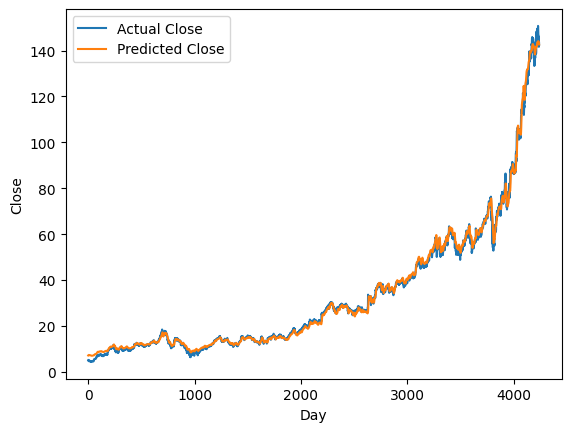

In [ ]:
import matplotlib.pyplot as plt
with torch.no_grad():
  train_predictions = model(X_train).detach().cpu().numpy().flatten()
y_train_pred, y_train_ = post_process(train_predictions, y_train)
plt.plot(y_train_, label='Actual Close')
plt.plot(y_train_pred, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

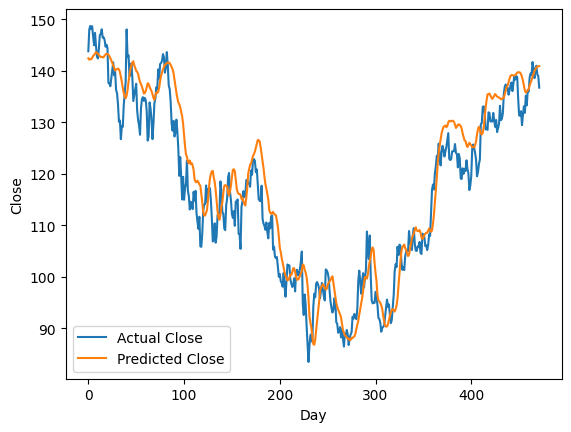

In [ ]:
test_predictions = model(X_test).detach().cpu().numpy().flatten()
y_test_pred, y_test_ = post_process(test_predictions, y_test)
plt.plot(y_test_, label='Actual Close')
plt.plot(y_test_pred, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()